In [1]:
versioninfo()

Julia Version 1.11.1
Commit 8f5b7ca12a (2024-10-16 10:53 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Windows (x86_64-w64-mingw32)
  CPU: 8 × Intel(R) Core(TM) i7-9700K CPU @ 3.60GHz
  WORD_SIZE: 64
  LLVM: libLLVM-16.0.6 (ORCJIT, skylake)
Threads: 1 default, 0 interactive, 1 GC (on 8 virtual cores)
Environment:
  JULIA_DEPOT_PATH = E:\Users\tate\.julia
  JULIA_PYTHONCALL_EXE = python


In [2]:
using Pkg
Pkg.activate(".")

  Activating project at `E:\Users\tate\Repo\article-logm-preconditioning`


In [3]:
using NLsolve
using PythonPlot

PythonPlot.matplotlib.rcParams["font.size"] = 10
PythonPlot.matplotlib.rcParams["axes.titlesize"] = 10;

In [4]:
# This template is introduced at http://www.cas.cmc.osaka-u.ac.jp/~paoon/Lectures/2018-7Semester-AppliedMath9/04-nlsolve/
function nls(func, params...; ini = [0.0])
    if typeof(ini) <: Number
        r = nlsolve((vout,vin)->vout[1]=func(vin[1],params...), [ini])
        v = r.zero[1]
    else
        r = nlsolve((vout,vin)->vout .= func(vin,params...), ini)
        v = r.zero
    end
    return v, r.f_converged
end

d0(λ) = asin(sqrt(
    (log(λ)^2 + 2*π^2 - sqrt((log(λ)^2 + 2*π^2)^2 - 4*π^4)) / (2*π^2)
))

function get_interval(λ_max, λ_min, ϵ)
    norm_A_minus_I = λ_max - 1
    norm_A_inv = 1 / λ_min
    ϵ_max = 3 * norm_A_minus_I * norm_A_inv / (1 + norm_A_inv)
    ϵ = ϵ < ϵ_max ? ϵ : ϵ_max / 2

    a = min(ϵ / 3 / norm_A_minus_I, 1 / 2 / norm_A_minus_I)
    α = (log(a) - log1p(-a)) / 2 # = atanh(2a-1)
    l = asinh(2 * α / pi)
    
    δ = a / norm_A_inv
    b1 = 1 - δ
    b2 = 2 * norm_A_inv / (2 * norm_A_inv + 1)
    if b1 >= b2
        β = (log1p(-δ) - log(δ))/2 # = atanh(2b1-1)
    else
        β = (log(b2) - log1p(-b2)) / 2 # = atanh(2b2-1)
    end
    r = asinh(2 * β / pi)
    return r - l
end

get_interval(κ) = get_interval(sqrt(κ), 1/sqrt(κ), 1e-12)

ρ_GL(κ) = 2 * log((κ^0.25 + 1) / (κ^0.25 - 1))
ρ_DE(κ) = 2*π*d0(sqrt(κ)) / get_interval(κ)
ρ_PGL(κ) = 2 * log((κ^0.125 + 1) / (κ^0.125 - 1)) / 2
ρ_PDE(κ) = 2*π*d0(κ^(0.25)) / get_interval(κ) / 2

GL_PGL = nls(log_κ -> ρ_GL(exp(log_κ)) - ρ_PGL(exp(log_κ)), ini=log(1e3))[1] |> exp
PGL_DE = nls(log_κ -> ρ_DE(exp(log_κ)) - ρ_PGL(exp(log_κ)), ini=log(1e3))[1] |> exp

@show GL_PGL
@show PGL_DE
@show ρ_PGL(GL_PGL)
@show ρ_PGL(PGL_DE)
;

GL_PGL = 130.9771533859376
PGL_DE = 298816.86332724825
ρ_PGL(GL_PGL) = 1.2187557270901928
ρ_PGL(PGL_DE) = 0.4196758175053671


sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


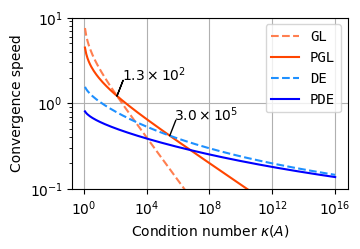

In [5]:
κ = 10.0 .^ LinRange(0, 16, 201)

fig, ax = subplots(1, 1, figsize=[10, 7]/2.7)
ax.plot(κ, ρ_GL.(κ), label="GL", c="coral", ls="--")
ax.plot(κ, ρ_PGL.(κ), label="PGL", c="orangered")
ax.plot(κ, ρ_DE.(κ), label="DE", c="dodgerblue", ls="--")
ax.plot(κ, ρ_PDE.(κ), label="PDE", c="blue")

xy1 = (GL_PGL, ρ_PGL(GL_PGL))
xy2 = (PGL_DE, ρ_PGL(PGL_DE))
xyt1 = (GL_PGL*2, ρ_PGL(GL_PGL)*1.5)
xyt2 = (PGL_DE*2, ρ_PGL(PGL_DE)*1.5)
ax.annotate("\$1.3\\times 10^2\$", xy1, xytext=xyt1, arrowprops=Dict("width"=>1, "headwidth"=>0))
ax.annotate("\$3.0\\times 10^5\$", xy2, xytext=xyt2, arrowprops=Dict("width"=>1, "headwidth"=>0))

ax.set_xlabel("Condition number \$\\kappa(A)\$")
ax.set_ylabel("Convergence speed")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xticks([1e0, 1e4, 1e8, 1e12, 1e16])
ax.set_yticks([1e-3, 1e-2, 1e-1, 1e0, 1e1])
ax.set_ylim(1e-1, 1e1)
ax.legend(prop=Dict("family"=>"monospace"))
ax.grid()

fig.tight_layout()
fig.savefig("fig/convergence_speed.pdf")
plotshow()